In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def calculate_median(data_list, start_index, end_index):
    return np.median([data['stop_time'] - data['start_time'] for data in data_list[start_index:end_index]])

In [3]:
def extract_avg_runtime(df):
    data_list = df[df['data'].notna()]['data']
    keys = data_list.index

    avgs = []
    BATCH_SIZE = 10

    for i in range(0, len(data_list), BATCH_SIZE):
        avg = calculate_median(data_list, i, i + BATCH_SIZE)
        config = keys[i].split(";")
        avgs.append((config[0], config[1], avg))

    df_data = pd.DataFrame(avgs, columns=['cores', 'input', 'exec_time'])
    return df_data

In [4]:
def extract_data(df):
    extracted_patterns = df.index.str.extract(r'(\d+);(\d+);(\d+)', expand=True)
    extracted_patterns.columns = ['cores', 'input', 'repetition']
    df[extracted_patterns.columns] = extracted_patterns[extracted_patterns.columns].values
    return df

In [18]:
dirs = os.listdir('./runs/')
df_model = pd.DataFrame()
df_real = pd.DataFrame()
df_model_random = pd.DataFrame()
df_model_single_last = pd.DataFrame()

for dir in dirs:
    files = os.listdir(f'./runs/{dir}')
    model_path = [f'./runs/{dir}/{f}' for f in files if f.endswith('.json') and 'model_linear_output' in f]
    real_path = [f'./runs/{dir}/{f}' for f in files if f.endswith('.json') and 'real_output' in f]
    random_path = [f'./runs/{dir}/{f}' for f in files if f.endswith('.json') and 'model_random_output' in f]
    single_last_path = [f'./runs/{dir}/{f}' for f in files if f.endswith('.json') and 'model_single_last_output' in f]
    
    df_model_aux = pd.read_json(model_path[0])
    df_real_aux = pd.read_json(real_path[0])
    df_random_aux = pd.read_json(random_path[0])

    # try:
    #     df_single_aux = pd.read_json(single_last_path[0])
    # except:
    #     pass

    df_model_aux['algorithm'] = dir
    df_real_aux['algorithm'] = dir
    df_random_aux['algorithm'] = dir
    # df_single_aux['algorithm'] = dir

    df_model_aux = df_model_aux[df_model_aux['data'].notna()][['data', 'algorithm']]
    df_real_aux = df_real_aux[df_real_aux['data'].notna()][['data', 'algorithm']]
    df_random_aux = df_random_aux[df_random_aux['data'].notna()][['data', 'algorithm']]
    # df_single_aux = df_single_aux[df_single_aux['data'].notna()][['data', 'algorithm']]

    df_model = pd.concat([df_model, df_model_aux])
    df_real = pd.concat([df_real, df_real_aux])
    df_model_random = pd.concat([df_model_random, df_random_aux])
    # df_model_single_last = pd.concat([df_model_single_last, df_single_aux])

In [19]:
df_model['exec_time'] = df_model['data'].apply(lambda x: x['stop_time'] - x['start_time'])
df_real['exec_time'] = df_real['data'].apply(lambda x: x['stop_time'] - x['start_time'])
df_model_random['exec_time'] = df_model_random['data'].apply(lambda x: x['stop_time'] - x['start_time'])
# df_model_single_last['exec_time'] = df_model_single_last['data'].apply(lambda x: x['stop_time'] - x['start_time'])

In [73]:
a = extract_data(df_model_random)
a = df_model_random.groupby(['cores', 'input', 'algorithm'])['exec_time'].mean().reset_index()
a[a['algorithm'] == 'raytrace']['cores'].unique()

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [68]:
df_real_raytrace = df_real[df_real['algorithm'] == 'raytrace']
df_real_raytrace = extract_avg_runtime(df_real_raytrace)
df_real_raytrace

,cores,input,exec_time
0,16,0,0.010846
1,16,1,0.016462
2,16,2,0.018291
3,16,3,0.022871
4,16,4,0.024371
...,...,...,...
251,1,11,0.371889
252,1,12,0.588244
253,1,13,0.831196
254,1,14,1.491479


In [7]:
df_model['data'] = df_model['data'].apply(lambda x: x if x['start_time'] != 0 else None)
df_model = df_model.dropna()

df_model_random['data'] = df_model_random['data'].apply(lambda x: x if x['start_time'] != 0 else None)
df_model_random = df_model_random.dropna()

# df_model_single_last['data'] = df_model_single_last['data'].apply(lambda x: x if x['start_time'] != 0 else None)
# df_model_single_last = df_model_single_last.dropna()

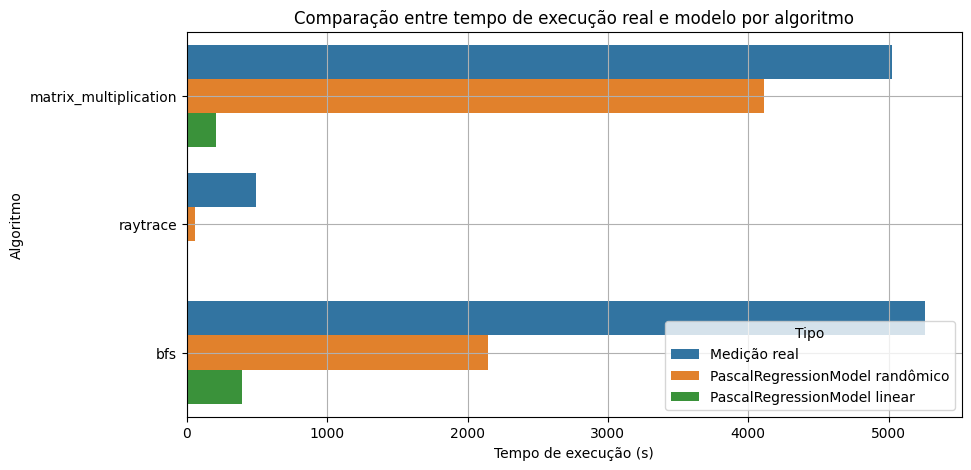

In [8]:
algorithms = df_real['algorithm'].unique()
data = []
for algo in algorithms:
    data.append({'Algoritmo': algo, 'Tipo': 'Medição real', 'Tempo': df_real[df_real['algorithm'] == algo]['exec_time'].sum()})
    data.append({'Algoritmo': algo, 'Tipo': 'PascalRegressionModel randômico', 'Tempo': df_model_random[df_model_random['algorithm'] == algo]['exec_time'].sum()})
    # data.append({'Algoritmo': algo, 'Tipo': 'PascalRegressionModel single e last core', 'Tempo': df_model_single_last[df_model_single_last['algorithm'] == algo]['exec_time'].sum()})
    data.append({'Algoritmo': algo, 'Tipo': 'PascalRegressionModel linear', 'Tempo': df_model[df_model['algorithm'] == algo]['exec_time'].sum()})

df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df, y='Algoritmo', x='Tempo', hue='Tipo', orient='h')

plt.ylabel('Algoritmo')
plt.xlabel('Tempo de execução (s)')
plt.title('Comparação entre tempo de execução real e modelo por algoritmo')
plt.legend(title='Tipo', loc='lower right')
plt.grid()
plt.show()